In [1]:
import functools
import numpy as np
import pandas as pd
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn import preprocessing

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
%matplotlib inline
plt.style.use('ggplot')

from data_provider import get_data
from simulation import get_match_feature_vector, post_match_results, post_simulation
from data_provider import append_player_data

In [2]:
dataset = get_data()
dataset.tail()

,id,date,home_team,away_team,home_score,away_score,tournament,city,country,year,...,away_Long_Shots,away_Aggression,away_Penalties,away_Marking,away_Standing_Tackle,away_GK_Diving,away_GK_Handling,away_GK_Kicking,away_GK_Positioning,away_GK_Reflexes
39051,39742,2018-06-27,Serbia,Brazil,0,0,FIFA World Cup,None,None,2018,...,80.6,85.8,85.333333,87.666667,88.2,82.5,80.5,86.5,82.0,86.5
39052,39743,2018-06-28,Japan,Poland,0,0,FIFA World Cup,None,None,2018,...,73.7,87.8,82.000000,80.333333,79.0,82.5,82.5,72.0,81.0,85.5
39053,39744,2018-06-28,Senegal,Colombia,0,0,FIFA World Cup,None,None,2018,...,76.4,84.8,81.666667,82.666667,82.2,49.0,43.0,45.5,45.0,50.0
39054,39745,2018-06-28,England,Belgium,0,0,FIFA World Cup,None,None,2018,...,80.5,86.8,83.333333,86.333333,86.2,84.0,82.0,73.0,82.0,86.0
39055,39746,2018-06-28,Panama,Tunisia,0,0,FIFA World Cup,None,None,2018,...,69.3,79.2,71.666667,74.333333,75.4,43.0,41.0,39.5,46.5,45.5


In [3]:
print("Dataset length", dataset.shape[0])
dataset = dataset.dropna()
print("Dataset complete cases length", dataset.shape[0])

Dataset length 39056
Dataset complete cases length 6676


In [4]:
dataset.columns

Index(['id', 'date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'year', 'simulation', 'home_elo',
       'away_elo', 'goal_diff_with_away', 'home_goals_with_away',
       'away_goals_with_home', 'home_goal_mean', 'away_goal_mean',
       'home_overall_rating_max', 'home_overall_rating_min',
       'home_overall_rating_avg', 'home_potential_max', 'home_potential_min',
       'home_potential_avg', 'home_height', 'home_weight', 'home_age',
       'home_top_11_age', 'home_weak_foot', 'home_international_reputation',
       'home_Crossing', 'home_Finishing', 'home_Heading_Accuracy',
       'home_Short_Passing', 'home_Dribbling', 'home_FK_Accuracy',
       'home_Long_Passing', 'home_Ball_Control', 'home_Acceleration',
       'home_Sprint_Speed', 'home_Reactions', 'home_Shot_Power',
       'home_Stamina', 'home_Strength', 'home_Long_Shots', 'home_Aggression',
       'home_Penalties', 'home_Marking', 'home_Standing_Tackle',
       'home_GK_Div

In [5]:
def calculate_relative_features(dataset):
    dataset["home_win"] = np.sign(dataset["home_score"] - dataset["away_score"])
    dataset["elo_diff"] = dataset["home_elo"] - dataset["away_elo"]
    dataset["rating_diff"] = dataset["home_overall_rating_avg"] - dataset["away_overall_rating_avg"]
    dataset["potential_diff"] = dataset["home_potential_avg"] - dataset["away_potential_avg"]
    dataset["height_diff"] = dataset["home_height"] - dataset["away_height"]
    dataset["weight_diff"] = dataset["home_weight"] - dataset["away_weight"]
    dataset["age_diff"] = dataset["home_age"] - dataset["away_age"]
    dataset["weak_foot_diff"] = dataset["home_weak_foot"] - dataset["away_weak_foot"]
    dataset["internationl_repuatiotion_diff"] = dataset["home_international_reputation"] - dataset["away_international_reputation"]
    dataset["crossing_diff"] = dataset["home_Crossing"] - dataset["away_Crossing"]
    dataset["finishing_diff"] = dataset["home_Finishing"] - dataset["away_Finishing"]
    dataset["heading_accuracy_diff"] = dataset["home_Heading_Accuracy"] - dataset["away_Heading_Accuracy"]
    dataset["short_passing_diff"] = dataset["home_Short_Passing"] - dataset["away_Short_Passing"]
    dataset["dribbling_diff"] = dataset["home_Dribbling"] - dataset["away_Dribbling"]
    dataset["fk_accuracy_diff"] = dataset["home_FK_Accuracy"] - dataset["away_FK_Accuracy"]
    dataset["long_passing_diff"] = dataset["home_Long_Passing"] - dataset["away_Long_Passing"]
    dataset["ball_control_diff"] = dataset["home_Ball_Control"] - dataset["away_Ball_Control"]
    dataset["acceleration_diff"] = dataset["home_Acceleration"] - dataset["away_Acceleration"]
    dataset["sprint_speed_diff"] = dataset["home_Sprint_Speed"] - dataset["away_Sprint_Speed"]
    dataset["reactions_diff"] = dataset["home_Reactions"] - dataset["away_Reactions"]
    dataset["shot_power_diff"] = dataset["home_Shot_Power"] - dataset["away_Shot_Power"]
    dataset["stamina_diff"] = dataset["home_Stamina"] - dataset["away_Stamina"]
    dataset["strength_diff"] = dataset["home_Strength"] - dataset["away_Strength"]
    dataset["long_shots_diff"] = dataset["home_Long_Shots"] - dataset["away_Long_Shots"]
    dataset["aggression_diff"] = dataset["home_Aggression"] - dataset["away_Aggression"]
    dataset["penalties_diff"] = dataset["home_Penalties"] - dataset["away_Penalties"]
    dataset["marking_diff"] = dataset["home_Marking"] - dataset["away_Marking"]
    dataset["standing_tackle_diff"] = dataset["home_Standing_Tackle"] - dataset["away_Standing_Tackle"]
    dataset["gk_diving_diff"] = dataset["home_GK_Diving"] - dataset["away_GK_Diving"]
    dataset["gk_handling_diff"] = dataset["home_GK_Handling"] - dataset["away_GK_Handling"]
    dataset["gk_kicking_diff"] = dataset["home_GK_Kicking"] - dataset["away_GK_Kicking"]
    dataset["gk_reflexes_diff"] = dataset["home_GK_Reflexes"] - dataset["away_GK_Reflexes"]
    #dataset["home_game"] = np.where(dataset['home_team']==dataset["country"], 1, 0)
    return dataset

dataset = calculate_relative_features(dataset)

In [6]:
feature_columns = ['home_elo',
       'away_elo', 'goal_diff_with_away', 'home_goals_with_away',
       'away_goals_with_home', 'home_goal_mean', 'away_goal_mean',
       'home_overall_rating_max', 'home_overall_rating_min',
       'home_overall_rating_avg', 'home_potential_max', 'home_potential_min',
       'home_potential_avg', 'home_height', 'home_weight', 'home_age',
       'home_top_11_age', 'home_weak_foot', 'home_international_reputation',
       'home_Crossing', 'home_Finishing', 'home_Heading_Accuracy',
       'home_Short_Passing', 'home_Dribbling', 'home_FK_Accuracy',
       'home_Long_Passing', 'home_Ball_Control', 'home_Acceleration',
       'home_Sprint_Speed', 'home_Reactions', 'home_Shot_Power',
       'home_Stamina', 'home_Strength', 'home_Long_Shots', 'home_Aggression',
       'home_Penalties', 'home_Marking', 'home_Standing_Tackle',
       'home_GK_Diving', 'home_GK_Handling', 'home_GK_Kicking',
       'home_GK_Positioning', 'home_GK_Reflexes', 'away_overall_rating_max',
       'away_overall_rating_min', 'away_overall_rating_avg',
       'away_potential_max', 'away_potential_min', 'away_potential_avg',
       'away_height', 'away_weight', 'away_age', 'away_top_11_age',
       'away_weak_foot', 'away_international_reputation', 'away_Crossing',
       'away_Finishing', 'away_Heading_Accuracy', 'away_Short_Passing',
       'away_Dribbling', 'away_FK_Accuracy', 'away_Long_Passing',
       'away_Ball_Control', 'away_Acceleration', 'away_Sprint_Speed',
       'away_Reactions', 'away_Shot_Power', 'away_Stamina', 'away_Strength',
       'away_Long_Shots', 'away_Aggression', 'away_Penalties', 'away_Marking',
       'away_Standing_Tackle', 'away_GK_Diving', 'away_GK_Handling',
       'away_GK_Kicking', 'away_GK_Positioning', 'away_GK_Reflexes']

In [7]:
feature_columns = ["elo_diff", "rating_diff", "potential_diff",
                   "height_diff", "weight_diff", "age_diff", "weak_foot_diff",
                   "internationl_repuatiotion_diff", "crossing_diff", "finishing_diff", "heading_accuracy_diff",
                   "short_passing_diff", "dribbling_diff", "fk_accuracy_diff", "long_passing_diff",
                   'ball_control_diff', 'acceleration_diff', 'sprint_speed_diff', "reactions_diff",
                   'shot_power_diff', 'stamina_diff', 'strength_diff', 'long_shots_diff',
                   "aggression_diff", "penalties_diff", "marking_diff", "standing_tackle_diff",
                   "away_goal_mean", "away_goals_with_home", "goal_diff_with_away", "home_goal_mean",
                   "home_goals_with_away", "gk_diving_diff", "gk_handling_diff", "gk_kicking_diff", "gk_reflexes_diff"]

wtl_col = "home_win"

In [8]:
no_friendly_or_wc = dataset[(dataset["tournament"] != "Friendly") & (dataset["tournament"] != "FIFA World Cup")]
print("No friendly or WC games length: ", no_friendly_or_wc.shape[0])

X = no_friendly_or_wc[feature_columns]
y = no_friendly_or_wc[wtl_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("No friendly games train set length: ", X_train.shape[0])

friendly_games = dataset[dataset["tournament"] == "Friendly"]
print("Friendly games length: ", friendly_games.shape[0])
X_friendly = friendly_games[feature_columns]
y_friendly = friendly_games[wtl_col]

X_train = pd.concat([X_train, X_friendly])
y_train = pd.concat([y_train, y_friendly])

wc_games = dataset[dataset["tournament"] == "FIFA World Cup"]
print("WC games length: ", wc_games.shape[0])
X_wc = wc_games[feature_columns]
y_wc = wc_games[wtl_col]
X_test = pd.concat([X_test, X_wc])
y_test = pd.concat([y_test, y_wc])

print("Whole train set length: ", X_train.shape[0])
print("Whole test set length: ", X_test.shape[0])
print("Train set width: ", X_train.shape[1])

No friendly or WC games length:  3788
No friendly games train set length:  2841
Friendly games length:  2760
WC games length:  128
Whole train set length:  5601
Whole test set length:  1075
Train set width:  36


In [9]:
no_friendly_or_wc

,id,date,home_team,away_team,home_score,away_score,tournament,city,country,year,...,strength_diff,long_shots_diff,aggression_diff,penalties_diff,marking_diff,standing_tackle_diff,gk_diving_diff,gk_handling_diff,gk_kicking_diff,gk_reflexes_diff
28531,28532,2007-01-07 00:00:00,Haiti,Bermuda,2,0,CFU Caribbean Cup qualification,Couva,Trinidad and Tobago,2007,...,11.475000,2.700000,16.650,19.066667,25.200000,11.350000,-0.5,8.5,31.5,7.5
28535,28536,2007-01-09 00:00:00,Bermuda,Haiti,0,3,CFU Caribbean Cup qualification,Couva,Trinidad and Tobago,2007,...,-11.475000,-2.700000,-16.650,-19.066667,-25.200000,-11.350000,0.5,-8.5,-31.5,-7.5
28541,28542,2007-01-12 00:00:00,Trinidad and Tobago,Barbados,1,1,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,2007,...,10.000000,2.800000,17.800,14.333333,44.166667,38.400000,53.5,52.0,29.5,57.0
28550,28551,2007-01-15 00:00:00,Haiti,Barbados,2,0,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,2007,...,-0.225000,-5.400000,3.150,4.666667,22.500000,10.450000,-4.5,2.5,21.5,0.5
28560,28561,2007-01-17 00:00:00,Trinidad and Tobago,Haiti,3,1,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,2007,...,10.225000,8.200000,14.650,9.666667,21.666667,27.950000,58.0,49.5,8.0,56.5
28578,28579,2007-01-23 00:00:00,Trinidad and Tobago,Haiti,1,2,CFU Caribbean Cup,Port of Spain,Trinidad and Tobago,2007,...,10.225000,8.200000,14.650,9.666667,21.666667,27.950000,58.0,49.5,8.0,56.5
28596,28597,2007-02-06 00:00:00,Cyprus,Hungary,2,1,Cyprus International Tournament,Limassol,Cyprus,2007,...,-11.620000,-5.300000,-5.200,2.000000,-6.000000,-16.000000,-65.0,-62.5,-12.5,-67.5
28599,28600,2007-02-06 00:00:00,Latvia,Bulgaria,0,2,Cyprus International Tournament,Larnaca,Cyprus,2007,...,-30.300000,-14.200000,-25.900,-15.000000,-33.166667,-59.900000,-64.5,-60.5,-29.0,-75.0
28611,28612,2007-02-07 00:00:00,Cyprus,Bulgaria,0,3,Cyprus International Tournament,Nicosia,Cyprus,2007,...,-13.920000,-16.000000,-14.200,-4.666667,-6.666667,-19.200000,-62.0,-61.0,-18.0,-73.0
28619,28620,2007-02-07 00:00:00,Latvia,Hungary,0,2,Cyprus International Tournament,Limassol,Cyprus,2007,...,-28.000000,-3.500000,-16.900,-8.333333,-32.500000,-56.700000,-67.5,-62.0,-23.5,-69.5


<Figure size 1440x432 with 0 Axes>

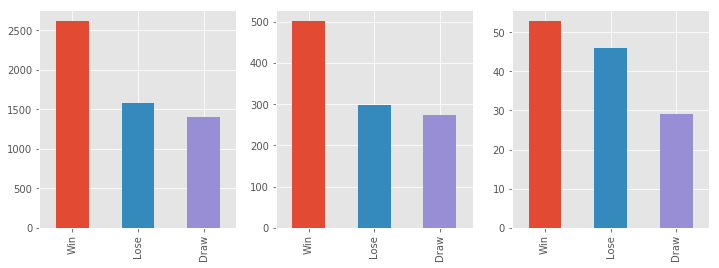

In [10]:
def get_labeled_df(s):
    df = pd.DataFrame(s)
    df[df["home_win"] == 1] = "Win"
    df[df["home_win"] == 0] = "Draw"
    df[df["home_win"] == -1] = "Lose"
    return df

plt.figure(figsize=(20, 6))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
pd.value_counts(get_labeled_df(y_train)["home_win"]).plot.bar(ax=axes[0])
pd.value_counts(get_labeled_df(y_test)["home_win"]).plot.bar(ax=axes[1])
pd.value_counts(get_labeled_df(y_wc)["home_win"]).plot.bar(ax=axes[2])

,elo_diff,rating_diff,potential_diff,height_diff,weight_diff,age_diff,weak_foot_diff,internationl_repuatiotion_diff,crossing_diff,finishing_diff,...,standing_tackle_diff,away_goal_mean,away_goals_with_home,goal_diff_with_away,home_goal_mean,home_goals_with_away,gk_diving_diff,gk_handling_diff,gk_kicking_diff,gk_reflexes_diff
elo_diff,1.000000,0.768263,0.764349,0.526812,0.429852,0.440573,0.452944,0.715562,0.690899,0.677783,...,0.590570,-0.506094,-0.476980,0.376161,0.519180,0.470400,0.475335,0.469402,0.485455,0.471936
rating_diff,0.768263,1.000000,0.972744,0.746898,0.630484,0.667048,0.565576,0.771418,0.763330,0.759745,...,0.720955,-0.386894,-0.423260,0.347228,0.404883,0.428269,0.532921,0.528641,0.523817,0.531525
potential_diff,0.764349,0.972744,1.000000,0.758652,0.624914,0.565770,0.558838,0.756279,0.761291,0.752981,...,0.720882,-0.375508,-0.420132,0.350729,0.406068,0.433871,0.539272,0.533952,0.525270,0.537124
height_diff,0.526812,0.746898,0.758652,1.000000,0.895993,0.663453,0.494474,0.473677,0.606666,0.631289,...,0.662650,-0.255919,-0.318857,0.214031,0.264098,0.307550,0.592007,0.582075,0.545031,0.586707
weight_diff,0.429852,0.630484,0.624914,0.895993,1.000000,0.602295,0.369072,0.397783,0.446622,0.511981,...,0.563930,-0.216996,-0.265828,0.161366,0.212440,0.242317,0.515912,0.506460,0.465313,0.507462
age_diff,0.440573,0.667048,0.565770,0.663453,0.602295,1.000000,0.445946,0.456132,0.540826,0.533233,...,0.563783,-0.233073,-0.270200,0.174657,0.194190,0.231443,0.464855,0.458195,0.443325,0.463056
weak_foot_diff,0.452944,0.565576,0.558838,0.494474,0.369072,0.445946,1.000000,0.399223,0.566223,0.548989,...,0.468177,-0.257964,-0.258899,0.184678,0.272406,0.244372,0.277264,0.269169,0.281104,0.272911
internationl_repuatiotion_diff,0.715562,0.771418,0.756279,0.473677,0.397783,0.456132,0.399223,1.000000,0.582554,0.578150,...,0.543390,-0.370723,-0.383184,0.373304,0.421508,0.393580,0.430368,0.424197,0.401385,0.424637
crossing_diff,0.690899,0.763330,0.761291,0.606666,0.446622,0.540826,0.566223,0.582554,1.000000,0.875387,...,0.787181,-0.336553,-0.382931,0.300616,0.358651,0.409113,0.456878,0.449244,0.494295,0.458291
finishing_diff,0.677783,0.759745,0.752981,0.631289,0.511981,0.533233,0.548989,0.578150,0.875387,1.000000,...,0.665058,-0.337126,-0.381828,0.287812,0.348312,0.401423,0.450883,0.443964,0.474417,0.453929


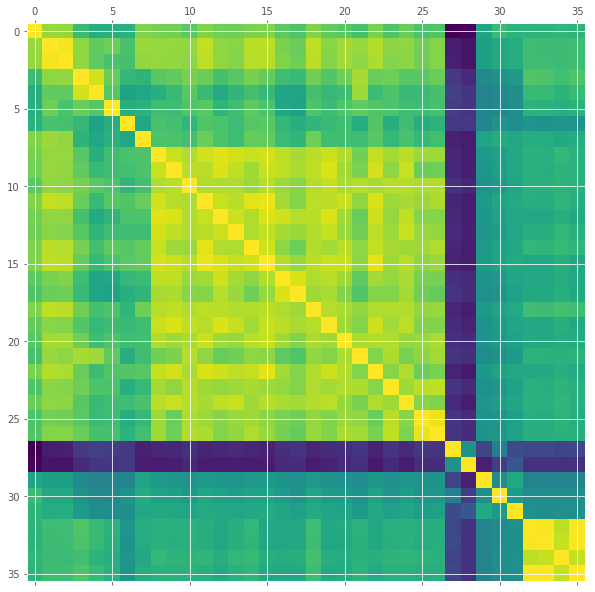

In [11]:
plt.figure(figsize=(10,10))
plt.matshow(X_train.corr(), fignum=1)
X_train.corr()

In [12]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [13]:
def get_feature_importance(clf):
    zipped = sorted(zip(feature_columns, clf.feature_importances_), key = lambda t: t[1], reverse=True)
    for feature, importance in zipped:
        print(f"{feature}: {importance}")

In [14]:
def run_random_search(clf, param_dist, 
                      Xtrain, ytrain, 
                      Xtest, ytest, 
                      X_wc, y_wc,
                      n_iter_search=60, custom_report_for_model=None):
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=n_iter_search)
    start = time()
    random_search.fit(Xtrain, ytrain)
    print("TRAIN SET METRICS:")
    print("SCORE: ", random_search.score(Xtrain, ytrain))
    y_true, y_pred = ytrain, random_search.predict(Xtrain)
    print(classification_report(y_true, y_pred))
    print("BEST PARAMS: ", random_search.best_params_)
    print()
    print()
    
    best_clf = random_search.best_estimator_
    best_clf.fit(Xtrain, ytrain)
    
    print("TEST SET METRICS:")
    print("SCORE: ", best_clf.score(Xtest, ytest))
    y_true, y_pred = ytest, best_clf.predict(Xtest)
    print("\n",classification_report(y_true, y_pred))
        
    print()
    print()
    print("WC SET METRICS:")
    print("SCORE: ", random_search.score(X_wc, y_wc))
    y_true, y_pred = y_wc, best_clf.predict(X_wc)
    print("\n",classification_report(y_true, y_pred))
    
    print()
    print()
    if custom_report_for_model:
        custom_report_for_model(best_clf)
    return best_clf

In [15]:
clf = RandomForestClassifier(oob_score=True, bootstrap=True, n_jobs=-1)

param_dist = {"n_estimators": [500],
              "max_depth": [8],
              "min_samples_leaf": [2],
              "max_features": ["sqrt"],
              "criterion": ["gini"]}
best_clf = run_random_search(clf, param_dist,
                             X_train, y_train, 
                             X_test, y_test, 
                             X_wc, y_wc,
                             custom_report_for_model=get_feature_importance, 
                             n_iter_search=1)

TRAIN SET METRICS:
SCORE:  0.687377254062
             precision    recall  f1-score   support

         -1       0.65      0.69      0.67      1575
          0       0.99      0.26      0.42      1402
          1       0.67      0.91      0.77      2624

avg / total       0.75      0.69      0.66      5601

BEST PARAMS:  {'n_estimators': 500, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'}


TEST SET METRICS:
SCORE:  0.561860465116

              precision    recall  f1-score   support

         -1       0.50      0.62      0.56       298
          0       0.33      0.02      0.03       274
          1       0.60      0.82      0.69       503

avg / total       0.50      0.56      0.49      1075



WC SET METRICS:
SCORE:  0.546875

              precision    recall  f1-score   support

         -1       0.59      0.50      0.54        46
          0       0.00      0.00      0.00        29
          1       0.53      0.89      0.67        53

avg / 

In [16]:
def run_simulation(matches):
    correct = 0
    total = 0
    for index, match in matches.iterrows():
        match = match.to_dict()
        match_sign, probas = predict_match_outcome(match)
        
        if match_sign == data["home_win"].item():
            print(f"{data['home_team'].item()} - {data['away_team'].item()}: ", end='')
            print(f"{match_sign[0]} -- PROBAS -- {probas}")
            correct +=1
        else:
            print(f"\x1b[31m\"{data['home_team'].item()} - {data['away_team'].item()}: \"\x1b[0m", end='')
            print(f"{match_sign[0]} -- CORRECT -- {data['home_win'].item()} -- PROBAS -- {probas}")
        total += 1
            
        data["home_score"] = 0
        data["away_score"] = 0
        data["tournament"] = "FIFA World Cup"
        data["year"] = 2018
        
        post_match_results(data)
    print(f"{correct}/{total}")

post_simulation()

In [32]:
def get_better_team(first_team, second_team):
    if first_team["points"] > second_team["points"]:
        return -1
    elif first_team["points"] < second_team["points"]:
        return 1
    
    if first_team["goal_diff"] > second_team["goal_diff"]:
        return -1
    elif first_team["goal_diff"] < second_team["goal_diff"]:
        return 1
    
    if first_team["goals_scored"] > second_team["goals_scored"]:
        return -1
    elif first_team["goals_scored"] < second_team["goals_scored"]:
        return 1
    
    f_name = first_team["Team"]
    s_name = second_team["Team"]
    if (first_team[f"{f_name}-{s_name}"] > 0):
        return -1
    elif (first_team[f"{f_name}-{s_name}"] < 0):
        return 1
    else:
        return - 1 if random.random() > 0.5 else -1

def sort_groups(table):
    next_round = pd.DataFrame()
    for group in np.unique(table["Group"]):
        group_df = table[table["Group"] == group]
        teams = [group_df.iloc[0], group_df.iloc[1], group_df.iloc[2], group_df.iloc[3]]
        shorted_standing = sorted(teams, key=functools.cmp_to_key(get_better_team))
        tmp = pd.concat([row.to_frame().T for row in shorted_standing])
        next_round = pd.concat([next_round, tmp])[["Team", "points", "Group"]]
    return next_round

def predict_match_outcome(match):
    data = get_match_feature_vector(match)
    data["home_win"] = np.sign(data["home_score"] - data["away_score"])

    x = calculate_relative_features(data)
    x = x[feature_columns]
    match_sign = best_clf.predict(x)
    probas = best_clf.predict_proba(x)
    
    data["home_score"] = 0
    data["away_score"] = 0
    data["tournament"] = "FIFA World Cup"
    data["year"] = 2018
    post_match_results(data)
    
    return match_sign, probas

In [35]:
group_table = pd.read_csv('data/original/world_cup_2018_dataset.csv')
group_table = group_table[["Team", "Group"]]
group_table['points'] = 0
group_table['goal_diff'] = 0
group_table['goals_scored'] = 0

wc_2018_matches = pd.read_csv('data/original/wc_2018_games.csv')

print("\n\n\n___Group Stage___\n")
for index, match in wc_2018_matches.iloc[0:48].iterrows():
    match = match.to_dict()
    match_sign, probas = predict_match_outcome(match)
    
    print(f"{match['home_team']} - {match['away_team']}: ", end='')
    print(f"{match_sign[0]} -- PROBAS -- {probas}")
    
    if match_sign == 1:
        group_table.loc[group_table["Team"] == match["home_team"], "points"] += 3
    elif match_sign == 0:
        group_table.loc[group_table["Team"] == match["home_team"], "points"] += 1
        group_table.loc[group_table["Team"] == match["away_team"], "points"] += 1
    elif match_sign == -1:
        group_table.loc[group_table["Team"] == match["away_team"], "points"] += 3
        
    home = match["home_team"]
    away = match["away_team"]
    group_table[f"{home}-{away}"] = match["home_score"] - match["away_score"]
    group_table[f"{away}-{home}"] = match["away_score"] - match["home_score"]
    
group_table = sort_groups(group_table)

i = 0
print("\n\n\n___Round of 16___\n")
for index, match in wc_2018_matches.iloc[48:56].iterrows():
    home_group, home_position = list(match["home_team"])
    away_group, away_position = list(match["away_team"])

    wc_2018_matches.loc[index, "home_team"] = group_table[group_table["Group"] == home_group].iloc[int(home_position)-1]["Team"]
    wc_2018_matches.loc[index, "away_team"] = group_table[group_table["Group"] == away_group].iloc[int(away_position)-1]["Team"]
    
    match = wc_2018_matches.loc[index].to_dict()
    match_sign, probas = predict_match_outcome(match)
    
    print(f"{match['home_team']} - {match['away_team']}: ", end='')
    print(f"{match_sign[0]} -- PROBAS -- {probas}")
    
    team_col = "home_team" if index%2 == 0 else "away_team" 
    
    if match_sign == 1:
        wc_2018_matches.loc[56 + i, team_col] = match["home_team"]
    else:
        wc_2018_matches.loc[56 + i, team_col] = match["away_team"]
        
    if index%2 != 0:
        i += 1
    
i = 0
print("\n\n\n___Quater Finals___\n")
for index, match in wc_2018_matches.iloc[56:60].iterrows():    
    match = wc_2018_matches.loc[index].to_dict()
    match_sign, probas = predict_match_outcome(match)
    print(f"{match['home_team']} - {match['away_team']}: ", end='')
    print(f"{match_sign[0]} -- PROBAS -- {probas}")
    
    team_col = "home_team" if index%2 == 0 else "away_team" 
    if match_sign == 1:
        wc_2018_matches.loc[60 + i, team_col] = match["home_team"]
    else:
        wc_2018_matches.loc[60 + i, team_col] = match["away_team"]
        
    if index%2 != 0:
        i += 1
        
print("\n\n\n___Semi Finals___\n")
for index, match in wc_2018_matches.iloc[60:62].iterrows():    
    match = wc_2018_matches.loc[index].to_dict()
    match_sign, probas = predict_match_outcome(match)
    print(f"{match['home_team']} - {match['away_team']}: ", end='')
    print(f"{match_sign[0]} -- PROBAS -- {probas}")
    team_col = "home_team" if index%2 == 0 else "away_team" 
    
    if match_sign == 1:
        wc_2018_matches.loc[63, team_col] = match["home_team"]
        wc_2018_matches.loc[62, team_col] = match["away_team"]
    else:
        wc_2018_matches.loc[63, team_col] = match["away_team"]
        wc_2018_matches.loc[62, team_col] = match["home_team"]
        

print("\n\n\n___Third place play-off___\n")
for index, match in wc_2018_matches.iloc[62:63].iterrows():    
    match = wc_2018_matches.loc[index].to_dict()
    match_sign, probas = predict_match_outcome(match)
    print(f"{match['home_team']} - {match['away_team']}: ", end='')
    print(f"{match_sign[0]} -- PROBAS -- {probas}")
    
print("\n\n\n___Final___\n")
for index, match in wc_2018_matches.iloc[63:].iterrows():    
    match = wc_2018_matches.loc[index].to_dict()
    match_sign, probas = predict_match_outcome(match)
    print(f"{match['home_team']} - {match['away_team']}: ", end='')
    print(f"{match_sign[0]} -- PROBAS -- {probas}")
    




___Group Stage___

Russia - Saudi Arabia: 1 -- PROBAS -- [[ 0.18019088  0.25709585  0.56271327]]
Egypt - Uruguay: -1 -- PROBAS -- [[ 0.42771566  0.29808332  0.27420102]]
Morocco - IR Iran: 1 -- PROBAS -- [[ 0.2440272   0.24390177  0.51207103]]
Portugal - Spain: 1 -- PROBAS -- [[ 0.32185757  0.33334121  0.34480122]]
France - Australia: 1 -- PROBAS -- [[ 0.10433209  0.20132341  0.6943445 ]]
Argentina - Iceland: 1 -- PROBAS -- [[ 0.09796467  0.18004047  0.72199486]]
Peru - Denmark: 1 -- PROBAS -- [[ 0.30596349  0.30213684  0.39189967]]
Croatia - Nigeria: 1 -- PROBAS -- [[ 0.12873285  0.2043365   0.66693065]]
Costa Rica - Serbia: -1 -- PROBAS -- [[ 0.33973789  0.33868424  0.32157787]]
Germany - Mexico: 1 -- PROBAS -- [[ 0.10985988  0.19234144  0.69779867]]
Brazil - Switzerland: 1 -- PROBAS -- [[ 0.13023282  0.22445805  0.64530913]]
Sweden - Korea Republic: 1 -- PROBAS -- [[ 0.19882196  0.27111291  0.53006513]]
Belgium - Panama: 1 -- PROBAS -- [[ 0.04343347  0.10671577  0.84985076]]
Tuni

In [30]:
wc_2018_matches

,id,away_score,away_team,date,home_score,home_team,group
0,0,0.0,Saudi Arabia,2018-06-14,5.0,Russia,A
1,1,1.0,Uruguay,2018-06-15,0.0,Egypt,A
2,2,1.0,IR Iran,2018-06-15,0.0,Morocco,B
3,3,3.0,Spain,2018-06-15,3.0,Portugal,B
4,4,1.0,Australia,2018-06-16,2.0,France,C
5,5,1.0,Iceland,2018-06-16,1.0,Argentina,D
6,6,1.0,Denmark,2018-06-16,0.0,Peru,C
7,7,0.0,Nigeria,2018-06-16,2.0,Croatia,D
8,8,1.0,Serbia,2018-06-17,0.0,Costa Rica,E
9,9,1.0,Mexico,2018-06-17,0.0,Germany,F
